# 任务 1 航班延误概率分析

- 目标：选择从纽约起飞频率最高的10个目的地机场，计算每个机场航班到达延误（`arr_delay > 0`）的概率，并绘制条形图。
- 步骤：
  1. 按目的地机场分组，统计航班数量并排序，选择前10个机场。
  2. 对每个机场，计算延误航班占总航班的比例。
  3. 绘制条形图，x轴为机场代码（按航班量降序排列），y轴为延误概率。
  4. 找出延误概率最高和最低的机场。
关键点：需处理缺失值，确保数据准确性。


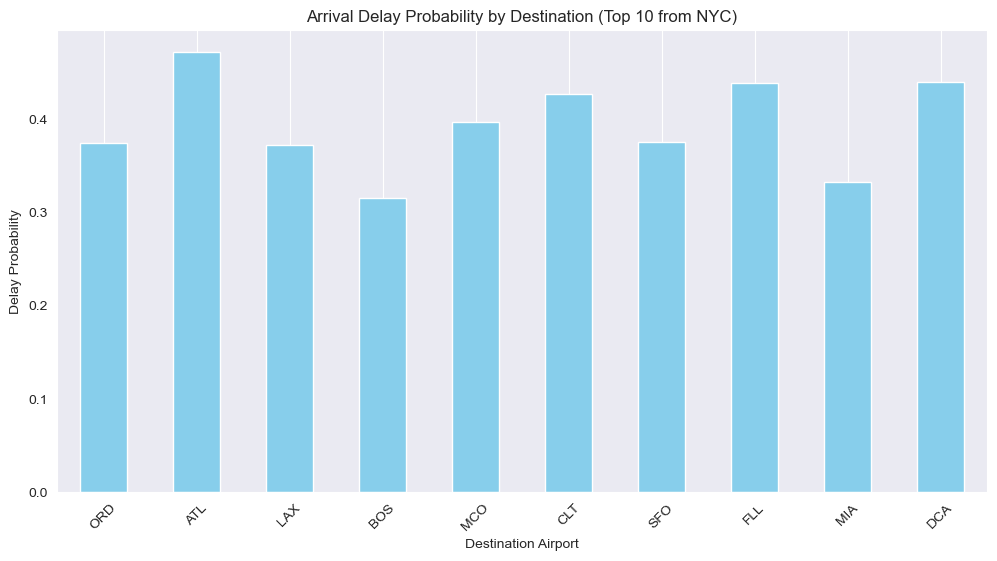

最高延误概率机场: ATL (47.19%)
最低延误概率机场: BOS (31.57%)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 数据加载
df = pd.read_csv('flights.csv')

# 任务1：航班延误概率分析
# 筛选纽约出发的航班（EWR/JFK/LGA）
ny_flights = df[df['origin'].isin(['JFK', 'LGA', 'EWR'])]

# 获取前10热门目的地
top_dests = ny_flights['dest'].value_counts().nlargest(10).index

# 数据清洗：移除缺失的到达延误数据
clean_df = ny_flights.dropna(subset=['arr_delay'])

# 计算延误概率
delay_probs = (clean_df[clean_df['dest'].isin(top_dests)]
               .groupby('dest')['arr_delay']
               .apply(lambda x: (x > 0).mean())
               .reindex(top_dests))

# 可视化
plt.figure(figsize=(12, 6))
delay_probs.plot(kind='bar', color='skyblue')
plt.title('Arrival Delay Probability by Destination (Top 10 from NYC)')
plt.xlabel('Destination Airport')
plt.ylabel('Delay Probability')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 结果输出
max_delay = delay_probs.idxmax()
min_delay = delay_probs.idxmin()
print(f"最高延误概率机场: {max_delay} ({delay_probs[max_delay]:.2%})")
print(f"最低延误概率机场: {min_delay} ({delay_probs[min_delay]:.2%})")

# 任务2：飞行时间分布分析（纽约→旧金山SFO）
- 目标：分析纽约到旧金山航班的飞行时间分布，假设其服从正态分布，估计参数并验证。
- 步骤：
  1. 提取所有纽约到SFO的航班，过滤缺失值。
  2. 绘制飞行时间的归一化直方图。
  3. 估计均值和标准差，绘制正态分布曲线叠加到直方图上。
  4. 计算95%置信区间的时间范围。
关键点：需验证正态性假设（如QQ图或检验），并确保区间计算正确。


In [ ]:
import numpy as np
from scipy import stats
import seaborn as sns

# 筛选纽约到SFO的航班
sfo_flights = df[(df['dest'] == 'SFO') &
                (df['origin'].isin(['JFK', 'LGA', 'EWR']))].dropna(subset=['air_time'])

# 正态性分析
air_time = sfo_flights['air_time']
mu, sigma = air_time.mean(), air_time.std()

# 可视化
plt.figure(figsize=(12, 6))
sns.histplot(air_time, kde=False, stat='density', bins=20)
x = np.linspace(air_time.min(), air_time.max(), 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
plt.title('Flight Time Distribution (NYC to SFO)')
plt.xlabel('Air Time (minutes)')
plt.ylabel('Density')

# 置信区间
ci = stats.norm.interval(0.95, loc=mu, scale=sigma)
print(f"95%置信区间: {ci[0]:.1f} - {ci[1]:.1f} minutes")

# QQ图验证
plt.figure(figsize=(12, 6))
stats.probplot(air_time, plot=plt)
plt.title('Q-Q Plot for Normality Check')
plt.show()

# 任务3：JFK航班起飞高峰时段分析
- 目标：分析JFK机场航班起飞的小时分布，找出上午和下午的高峰时段，比较延误差异。
- 步骤：
  1. 提取JFK的航班，将起飞时间转换为小时（向下取整）。
  2. 绘制每小时起飞航班数的分布图，识别两个高峰时段。
  3. 计算这两个时段的平均起飞延误（`dep_delay`）。
  4. 使用统计检验（如t检验）判断差异是否显著。
关键点：注意时间格式转换，选择适当的统计检验方法。


In [ ]:
from scipy import stats

# 筛选JFK航班
jfk_flights = df[df['origin'] == 'JFK'].dropna(subset=['dep_time', 'dep_delay'])

# 转换起飞时间到小时
jfk_flights['hour'] = (jfk_flights['dep_time'] // 100).clip(0, 23)

# 小时分布分析
hour_counts = jfk_flights['hour'].value_counts().sort_index()

# 可视化
plt.figure(figsize=(12, 6))
hour_counts.plot(kind='bar', color='teal')
plt.title('Departure Distribution at JFK by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 24), rotation=0)
plt.show()

# 自动识别高峰时段（取前2个）
peak_hours = hour_counts.nlargest(2).index.sort_values()

# 比较延误差异
morning = jfk_flights[jfk_flights['hour'] == peak_hours[0]]['dep_delay']
afternoon = jfk_flights[jfk_flights['hour'] == peak_hours[1]]['dep_delay']

# t检验
t_stat, p_value = stats.ttest_ind(morning, afternoon, equal_var=False)
print(f"高峰时段 {peak_hours[0]}时 vs {peak_hours[1]}时")
print(f"平均延误: {morning.mean():.1f} vs {afternoon.mean():.1f} 分钟")
print(f"独立t检验 p值: {p_value:.4f}")

# 任务4：飞行时间波动性与距离的关系
- 目标：研究飞行时间标准差与飞行距离的关系，建立线性回归模型。
- 步骤：
  1. 按目的地机场分组，计算飞行时间的标准差和平均距离。
  2. 绘制散点图（x=距离，y=标准差）。
  3. 拟合线性回归模型，绘制回归线。
  4. 改进模型（如添加距离平方项），比较模型精度（如R²）。
关键点：检查线性假设，可能需要非线性特征（如多项式）。


In [ ]:
import statsmodels.api as sm

# 按机场分组计算统计量
grouped = df.groupby('dest').agg(
    flight_count=('flight', 'count'),
    time_std=('air_time', 'std'),
    distance=('distance', 'mean')
).dropna().query('flight_count > 30')  # 过滤小样本

# 线性回归
X = sm.add_constant(grouped['distance'])
model = sm.OLS(grouped['time_std'], X).fit()

# 多项式回归
grouped['distance_sq'] = grouped['distance']**2
X_poly = sm.add_constant(grouped[['distance', 'distance_sq']])
model_poly = sm.OLS(grouped['time_std'], X_poly).fit()

# 结果比较
print("线性模型R²:", model.rsquared)
print("多项式模型R²:", model_poly.rsquared)

# 可视化
plt.figure(figsize=(12, 6))
plt.scatter(grouped['distance'], grouped['time_std'], alpha=0.6)
plt.plot(grouped['distance'], model.predict(X), color='red', label='Linear')
plt.plot(grouped['distance'], model_poly.predict(X_poly), color='green', label='Quadratic')
plt.xlabel('Flight Distance')
plt.ylabel('Air Time Standard Deviation')
plt.title('Flight Time Variability vs Distance')
plt.legend()
plt.show()